# **5. Transfer learning with VGG-16**

In this series of notebooks, we will go over the VGG architecture. We will fine-tune the VGG-16 architecture, and its more complex successor VGG-19.

# Introduction

VGG-16 is a convolutional neural network (CNN) architecture that was developed by the Visual Geometry Group at the University of Oxford. It is trained on the ImageNet dataset.

VGG-16 has a total of 16 layers, which include 13 convolutional layers and 3 fully connected layers. The convolutional layers in VGG-16 use small 3×3 filters with a stride of 1 and same padding, After each convolutional layer, there is a max pooling layer with a 2×2 filter and a stride of 2 pixels. Number of filters increases from 64 to 128 to 256 to 512 (with 512 being used twice). As same padding is used, only the pooling layers shrink the dimensions of the images. 

![vgg.png](./docs/VGG-16_Architecture.png)

This network is large even by modern standards. It has around 138 million parameters (most of them in the fully connected layers). It has a total memory of 96MB per image, only for forward propagation. Therefore, we will use it for feature extraction only and then train a fully-connected classifier on those features.

**Source:** Simonyan, K., & Zisserman, A. (2014). Very Deep Convolutional Networks for Large-Scale Image Recognition. arXiv preprint arXiv:1409.1556. [Online]. Available: https://arxiv.org/abs/1409.1556

In [1]:
# Base libraries
import os

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

# Tensorflow
import tensorflow.keras as keras
from tensorflow import debugging as tfdbg
from tensorflow import device
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# VGG-19
from tensorflow.keras.applications import VGG16

# Own modules
from src.utils import drop_checkpoints, dataset_stats, plot_metric_curves, extract_features

2023-04-02 19:12:04.770435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 19:12:04.933305: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-02 19:12:04.933325: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-02 19:12:05.746280: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

Now let's see how our data is structured:

In [2]:
# Root folder
base_dir = "./data"

In [3]:
# Train folder
train_dir = os.path.join(base_dir, "train")

# Validation folder
validation_dir = os.path.join(base_dir, "validation")

# Test folder
test_dir = os.path.join(base_dir, "test")

In [4]:
drop_checkpoints(base_dir)

Let's also see how many images there are for each class in the training, validation and test set.

In [5]:
dataset_stats(train_dir, validation_dir, test_dir)

Number of classes: 4
Existing classes: ['Renaissance', 'Realism', 'Baroque', 'Romanticism']

----------------------------------------
Number of images per class and dataset:
----------------------------------------
             Train  Validation  Test
Style                               
Renaissance   4000         500   500
Realism       4000         500   500
Baroque       4000         500   500
Romanticism   4000         500   500


We'll also create the directory, if not created yet, where the models will be saved:

In [6]:
# Create directory where to save the models created
models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

# 5.1 Model structure

In [7]:
# Define some hyperparameters' values

# Input shape
input_shape = (224, 224,  3)

# Batch_size and steps per epoch
training_size = sum([len(file) for path, folder, file in os.walk(train_dir)])
batch_size = 128
steps_per_epoch = training_size // batch_size
print(f"Steps per epoch: {steps_per_epoch}")

Steps per epoch: 125


The first thing we will do is load the `VGG16` model, which is already included in the `keras` library. We will set `include_top=False` so that we can load just the convolutional part of the model, as we want to train our own DNN to perform the classification task. 

In [8]:
model = models.Sequential()

# initialize convolutional base for the model - based on VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  pooling=None,
                  input_shape=input_shape)

conv_base.summary()

2023-04-02 19:12:06.602184: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-02 19:12:06.602924: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-02 19:12:06.602960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2023-04-02 19:12:06.604701: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

We can now create our DNN classifier:

In [9]:
last_layer_shape = (7, 7, 512)
last_layer_size = last_layer_shape[0]*last_layer_shape[1]*last_layer_shape[2]

In [10]:
# Create the model
model = models.Sequential()

model.add(layers.Dense(256, activation='relu', input_dim=last_layer_size))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))

# Output layer
model.add(layers.Dense(4, activation='softmax'))

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 6,456,196
Trainable params: 6,456,196
Non-trainable params: 0
_________________________________________________________________


We'll use Adam as our optimizer since it is the most popular optimizer right now, as well as versatile (i.e., it can be used in multiple contexts).

In [12]:
optimizer = optimizers.Adam(learning_rate=1e-4)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['acc']
)

# 5.2. Data preprocessing

In this case, we will include the Data Augmentation step to the model preprocessing step

In [13]:
# Apply data augmentation to the training set
# https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1),
    zoom_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest'
    )

# The data augmentation must not be used for the test set!
# All images will be rescaled by 1./255
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        # All images will be resized to the dimensions specified
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
        )

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        # All images will be resized to the dimensions specified
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
        )

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=input_shape[:2],
        batch_size=40,
        class_mode='categorical',
        shuffle=False
)

Found 16000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


We can now use `VGG16` to extract features from the images:

In [15]:
train_features, train_labels = extract_features(16000, last_layer_shape, conv_base, train_generator, batch_size)
validation_features, validation_labels = extract_features(2000, last_layer_shape, conv_base, validation_generator, batch_size)
test_features, test_labels = extract_features(2000, last_layer_shape, conv_base, test_generator, 40)

# Flatten features prior to feeding them to the classifier
train_features = np.reshape(train_features, (16000, last_layer_size))
validation_features = np.reshape(validation_features, (2000, last_layer_size))
test_features = np.reshape(test_features, (2000, last_layer_size))

4/4 [==============================] - 19s 5s/step


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


2/2 [==============================] - 6s 1s/step


In [16]:
for data_batch, labels_batch in train_generator:
    print('Data batch shape:', data_batch.shape)
    print('Labels batch shape:', labels_batch.shape)
    break

Data batch shape: (128, 224, 224, 3)
Labels batch shape: (128, 4)


# 5.3. Training

Let's train the model.

In [17]:
# Model name and path
model_path = os.path.join("models", "vgg16_model.h5")

In [18]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(model_path, monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [19]:
history = model.fit(
    train_features, train_labels,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=(validation_features, validation_labels),
    validation_steps=20,
    callbacks = [es, mc]
)

Epoch 1/30


2023-04-02 20:11:00.249926: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1605632000 exceeds 10% of free system memory.


125/125 [==============================] - ETA: 0s - loss: 1.1637 - acc: 0.4818
Epoch 1: val_loss improved from inf to 1.11144, saving model to models/vgg16_model.h5
125/125 [==============================] - 8s 57ms/step - loss: 1.1637 - acc: 0.4818 - val_loss: 1.1114 - val_acc: 0.4930
Epoch 2/30
125/125 [==============================] - ETA: 0s - loss: 1.0163 - acc: 0.5697
Epoch 2: val_loss improved from 1.11144 to 0.99006, saving model to models/vgg16_model.h5
125/125 [==============================] - 7s 54ms/step - loss: 1.0163 - acc: 0.5697 - val_loss: 0.9901 - val_acc: 0.5825
Epoch 3/30
125/125 [==============================] - ETA: 0s - loss: 0.9223 - acc: 0.6191
Epoch 3: val_loss improved from 0.99006 to 0.95799, saving model to models/vgg16_model.h5
125/125 [==============================] - 7s 54ms/step - loss: 0.9223 - acc: 0.6191 - val_loss: 0.9580 - val_acc: 0.6095
Epoch 4/30
124/125 [============================>.] - ETA: 0s - loss: 0.8559 - acc: 0.6492
Epoch 4: val_lo

Now let's load the best model found:

In [20]:
# load the saved model
vgg16_model = load_model(model_path)

# 5.4. Validation

Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

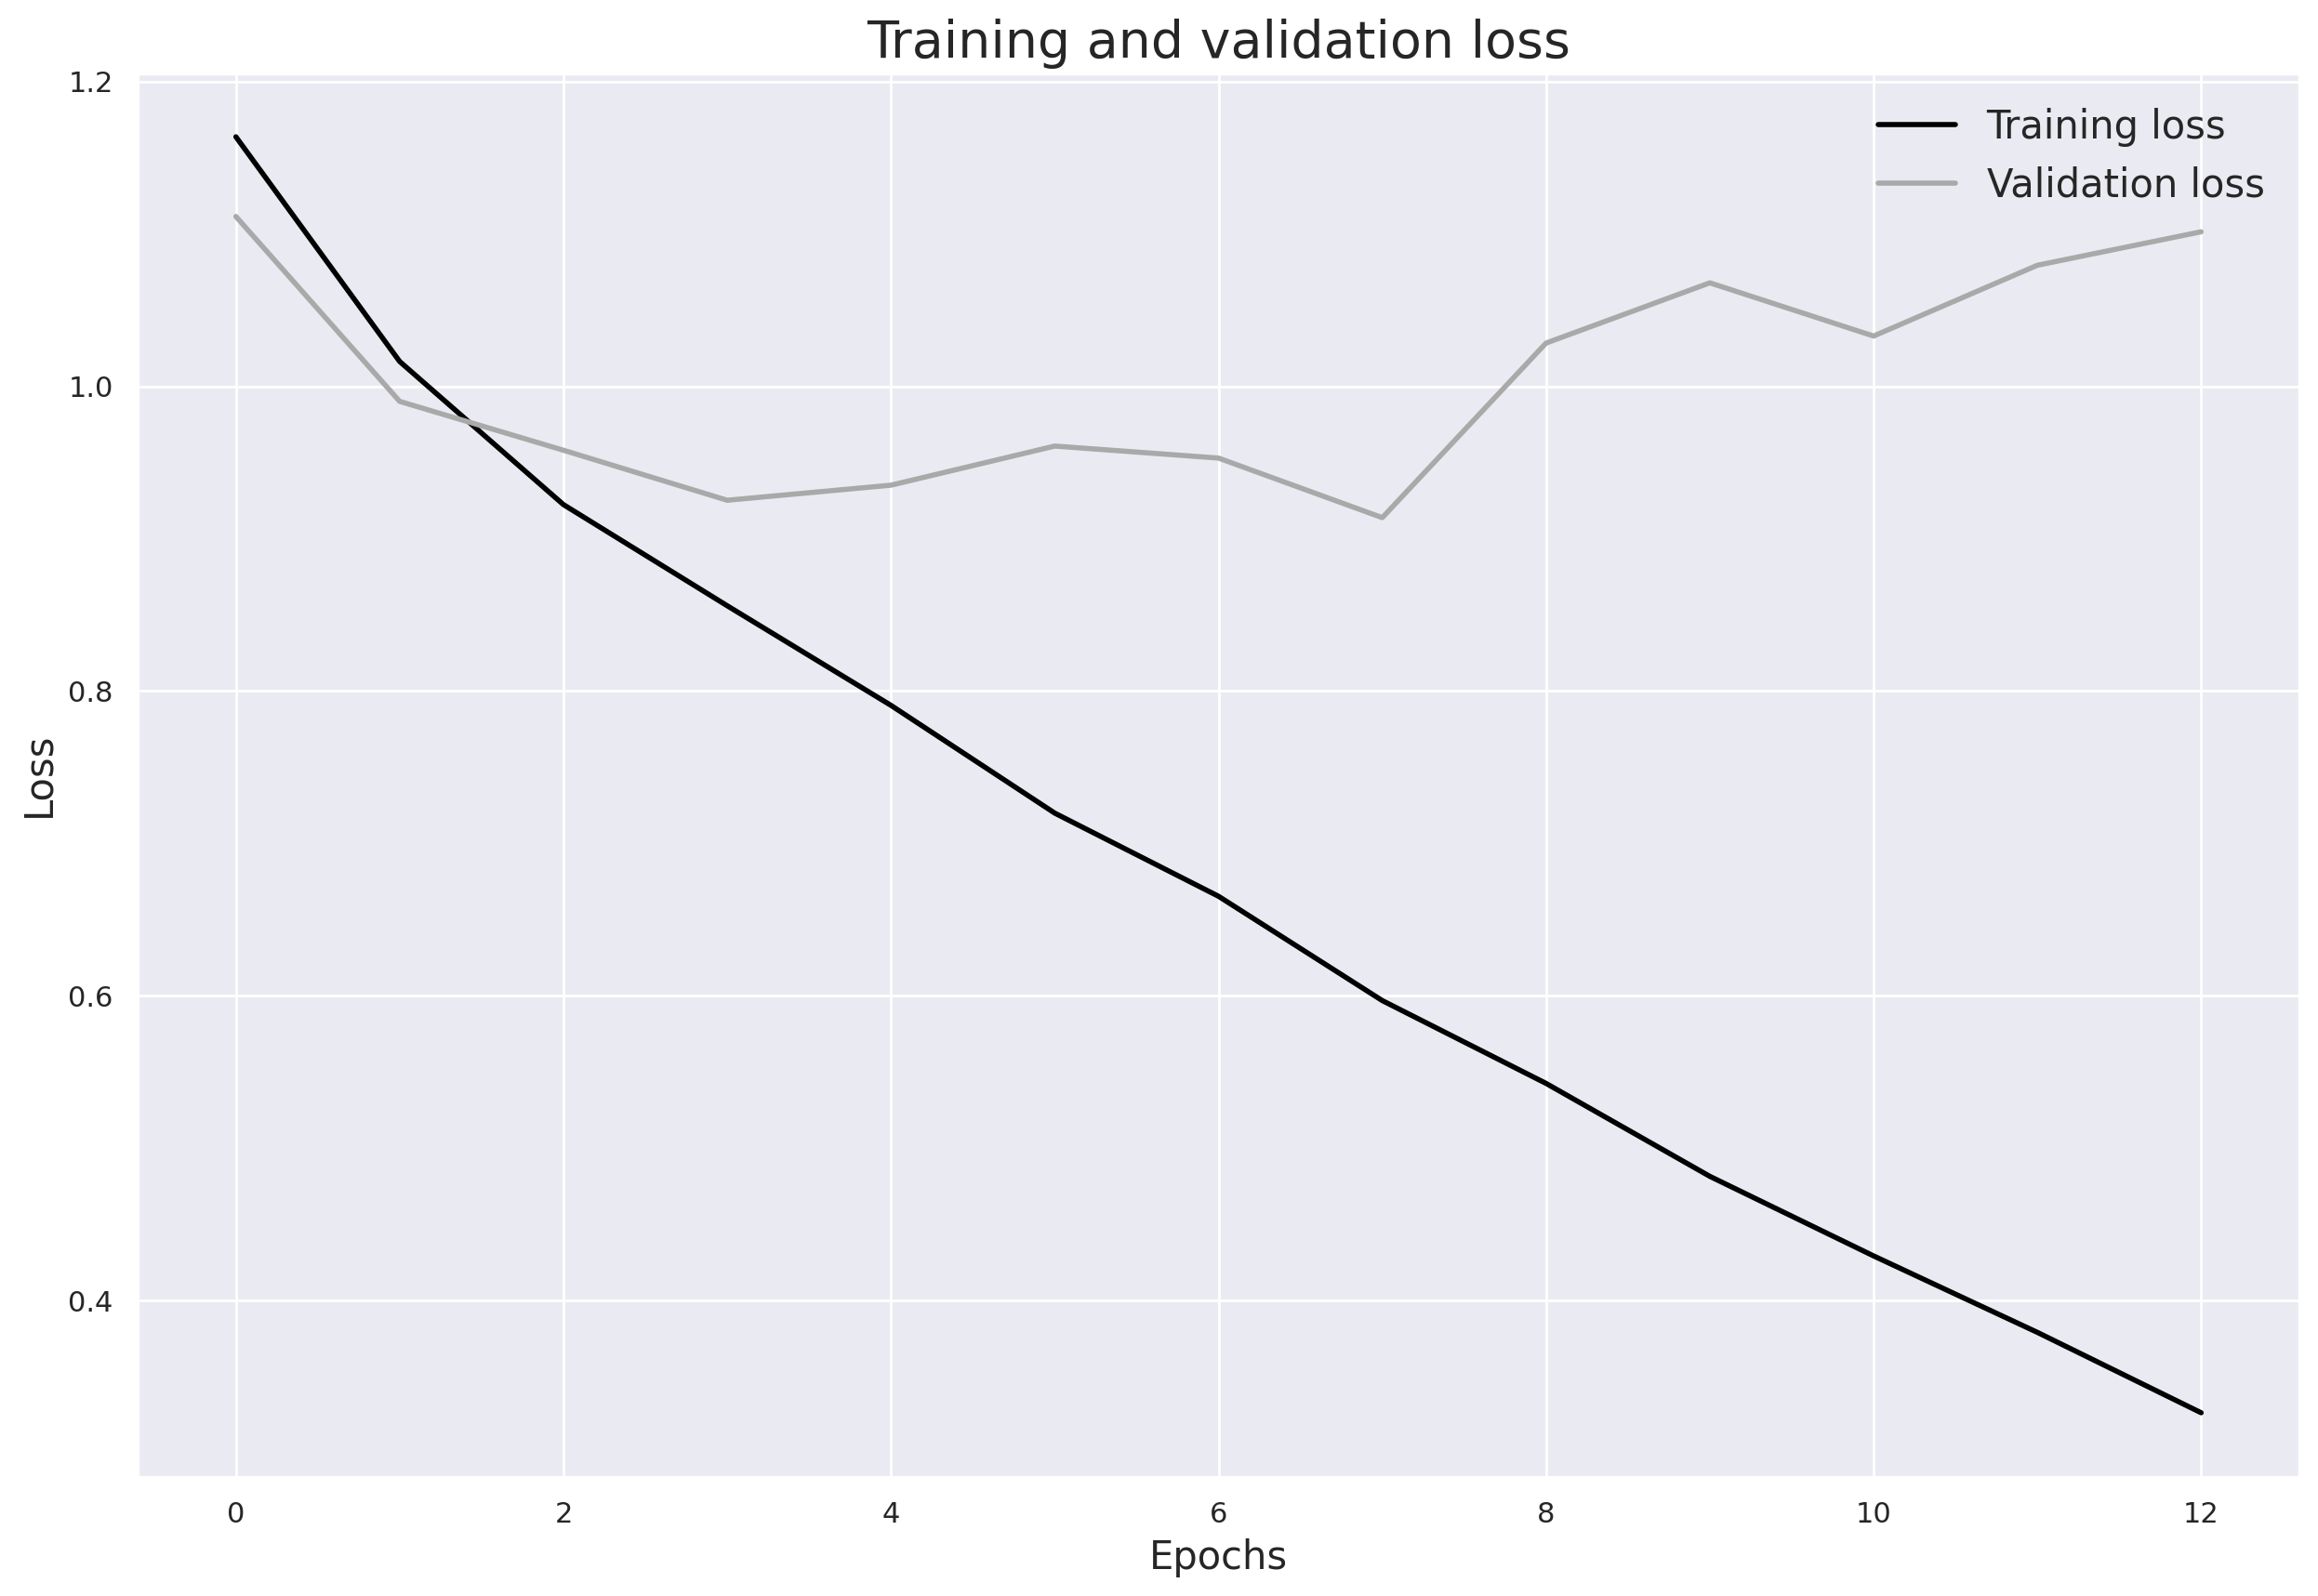

In [22]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "black", "darkgray", "Loss")

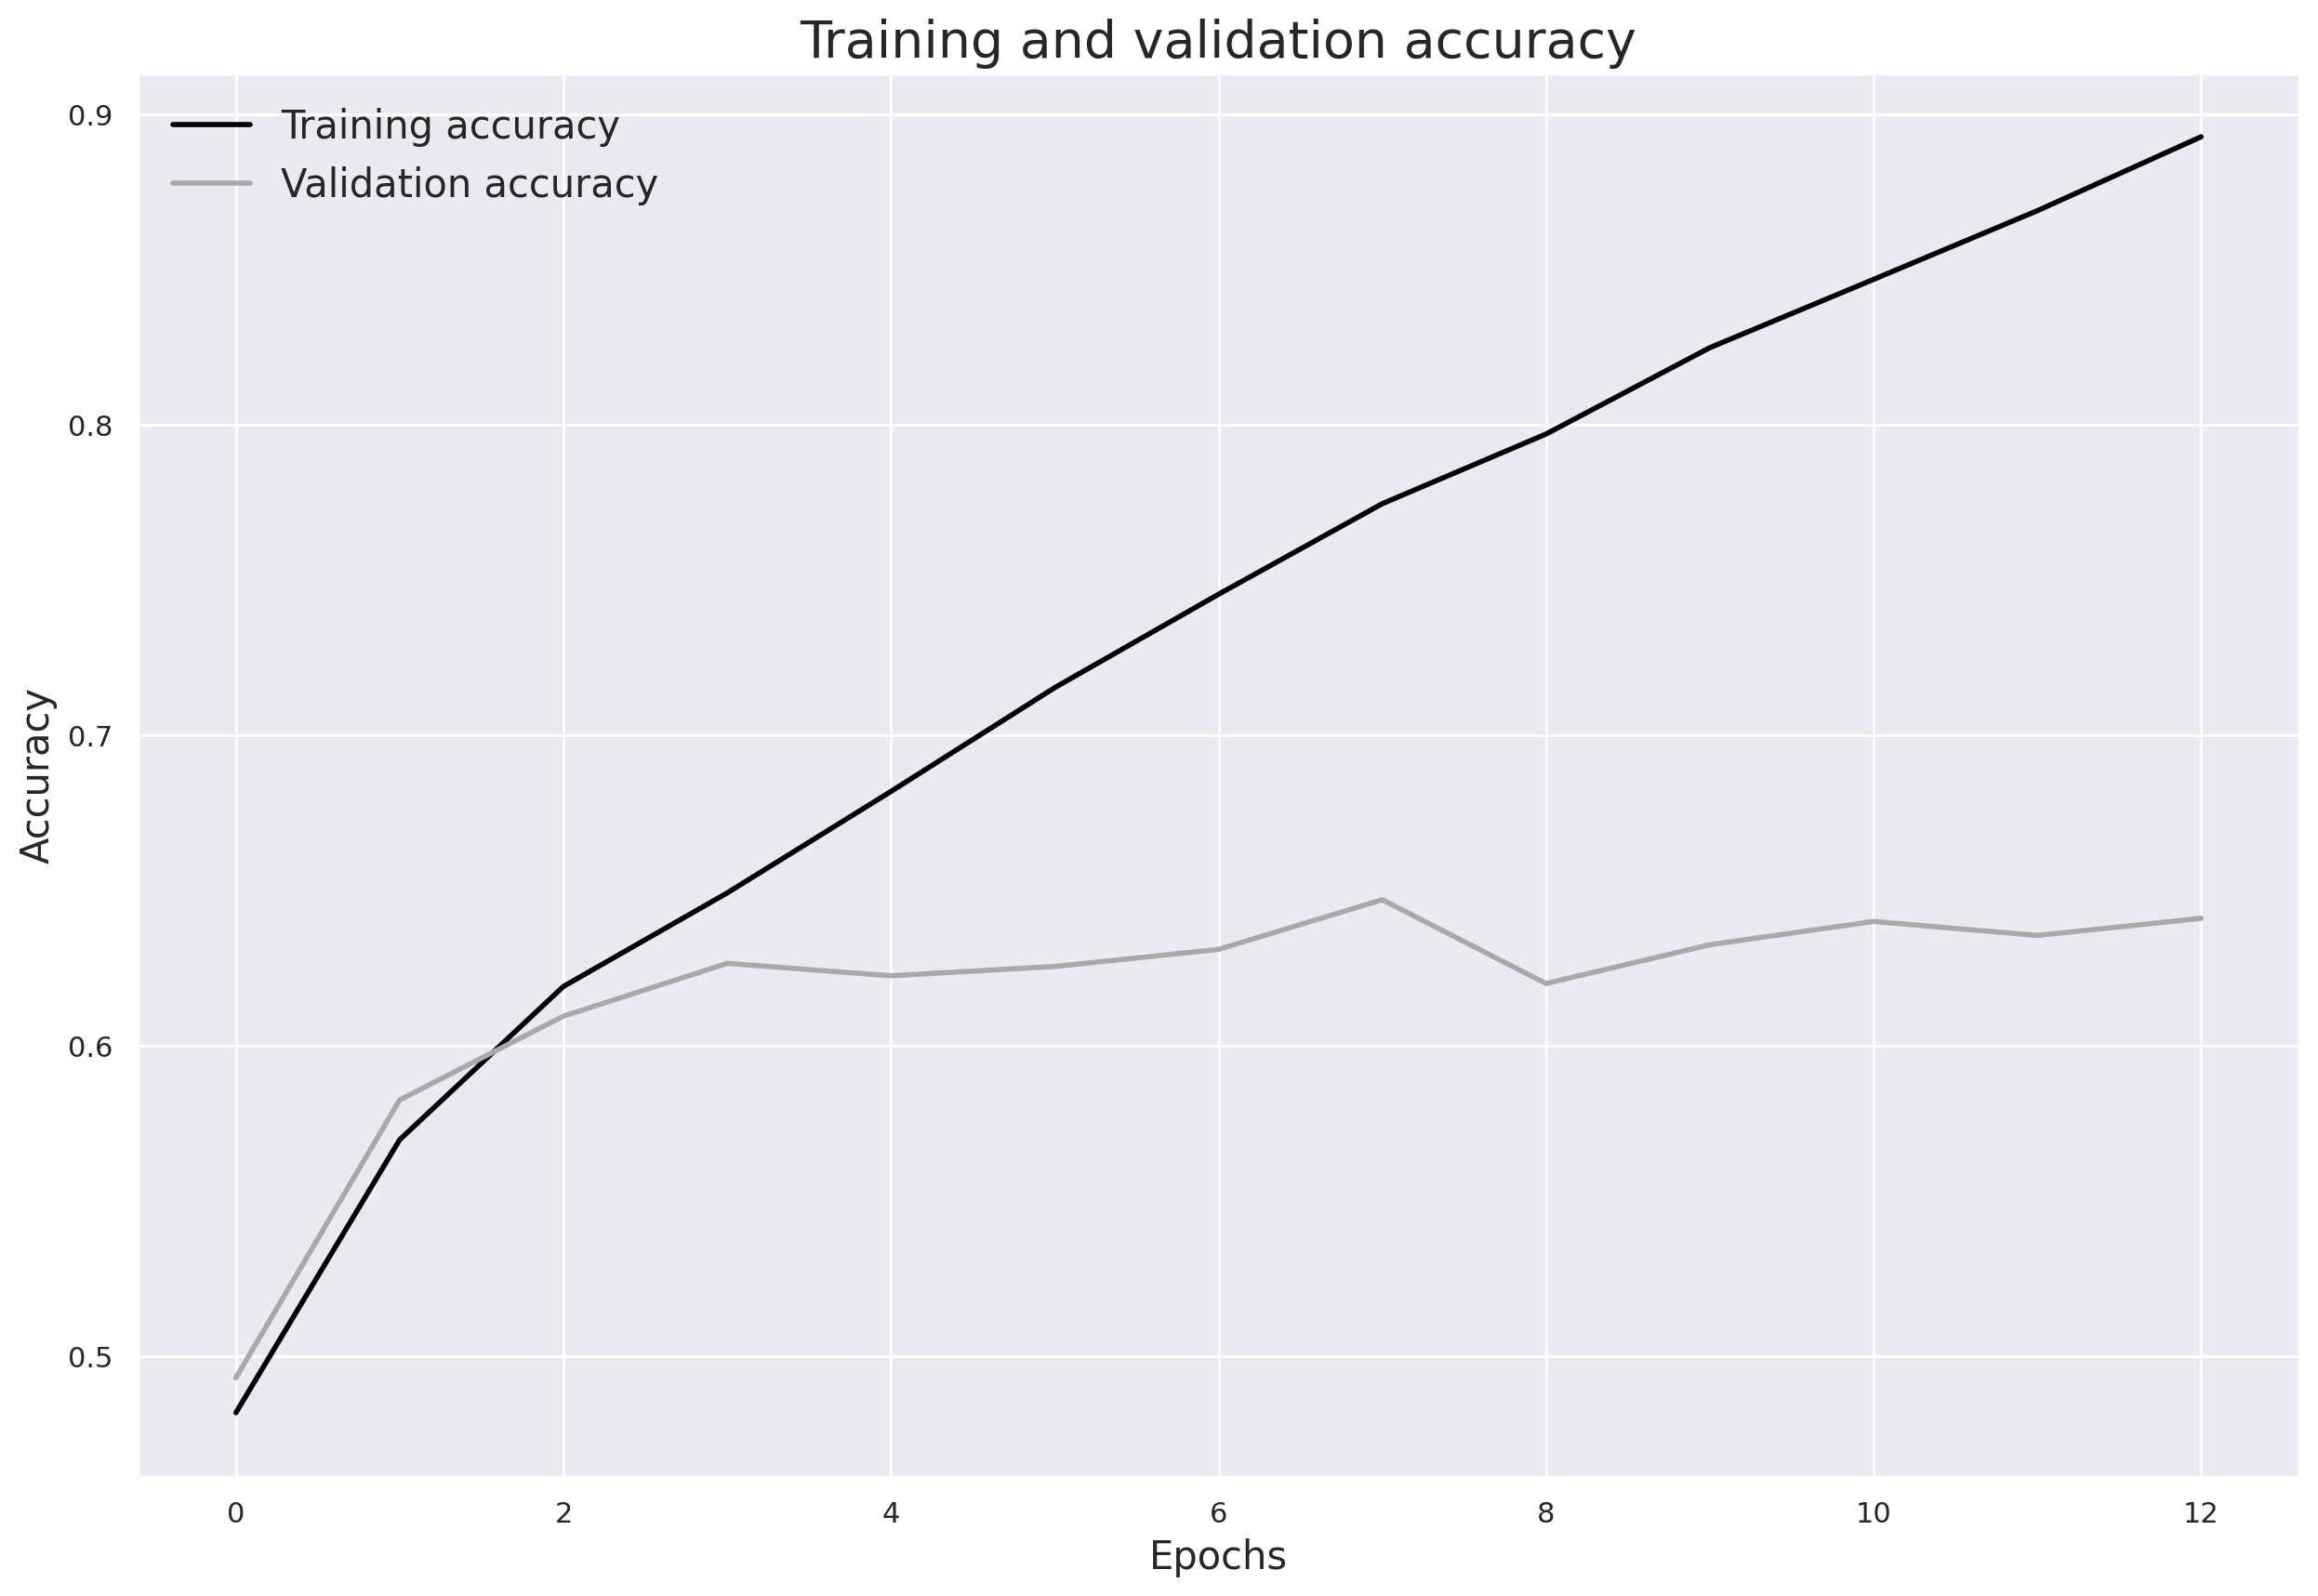

In [23]:
# Plot accuracy curves
plot_metric_curves(epochs, acc, val_acc, "black", "darkgray", "Accuracy")

In [24]:
vgg16_model.evaluate(test_features, test_labels)

63/63 [==============================] - 1s 7ms/step - loss: 0.8927 - acc: 0.6370


[0.8927139043807983, 0.6370000243186951]

The above plots clearly demonstrate that the model is overfitting, with an accuracy of roughly 90% on the training set but only 64% on the test set. Unfortunately, these results are comparable to those obtained with our models trained from scratch. Thus, it appears that simple feature extraction is insufficient for achieving significant improvements over our prior benchmarks.